## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression, NormalKnownVariancePriorLinearRegression
from src.utils import get_toy_data, plot_ppds

from src.attacks.distr_attacks import fgsm_attack, mlmc_attack, mlmc_gradient_estimator, kl_div, kl_maximization, kl_to_appd

import numpy as np
import torch
from torch.optim import SGD
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

import time
from joblib import Parallel, delayed

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
# set all seeds for reproducibility
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
X, y = get_toy_data()

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Model for which we know the true gradient
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

## APPD = N(mu, 2*sigma)

### Check gradient

In [5]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * sigma2)
lr = 0.0
mu_n = model.mu
lam_n = model.lam
sigma2 = model.sigma2
x_adv = x.clone().detach().requires_grad_(True)  
optimizer = SGD([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = kl_to_appd(mu_n, lam_n, sigma2, x_adv, x.T @ model.mu, 2 * sigma2)
kl.backward()
real_grad = x_adv.grad.clone().detach()

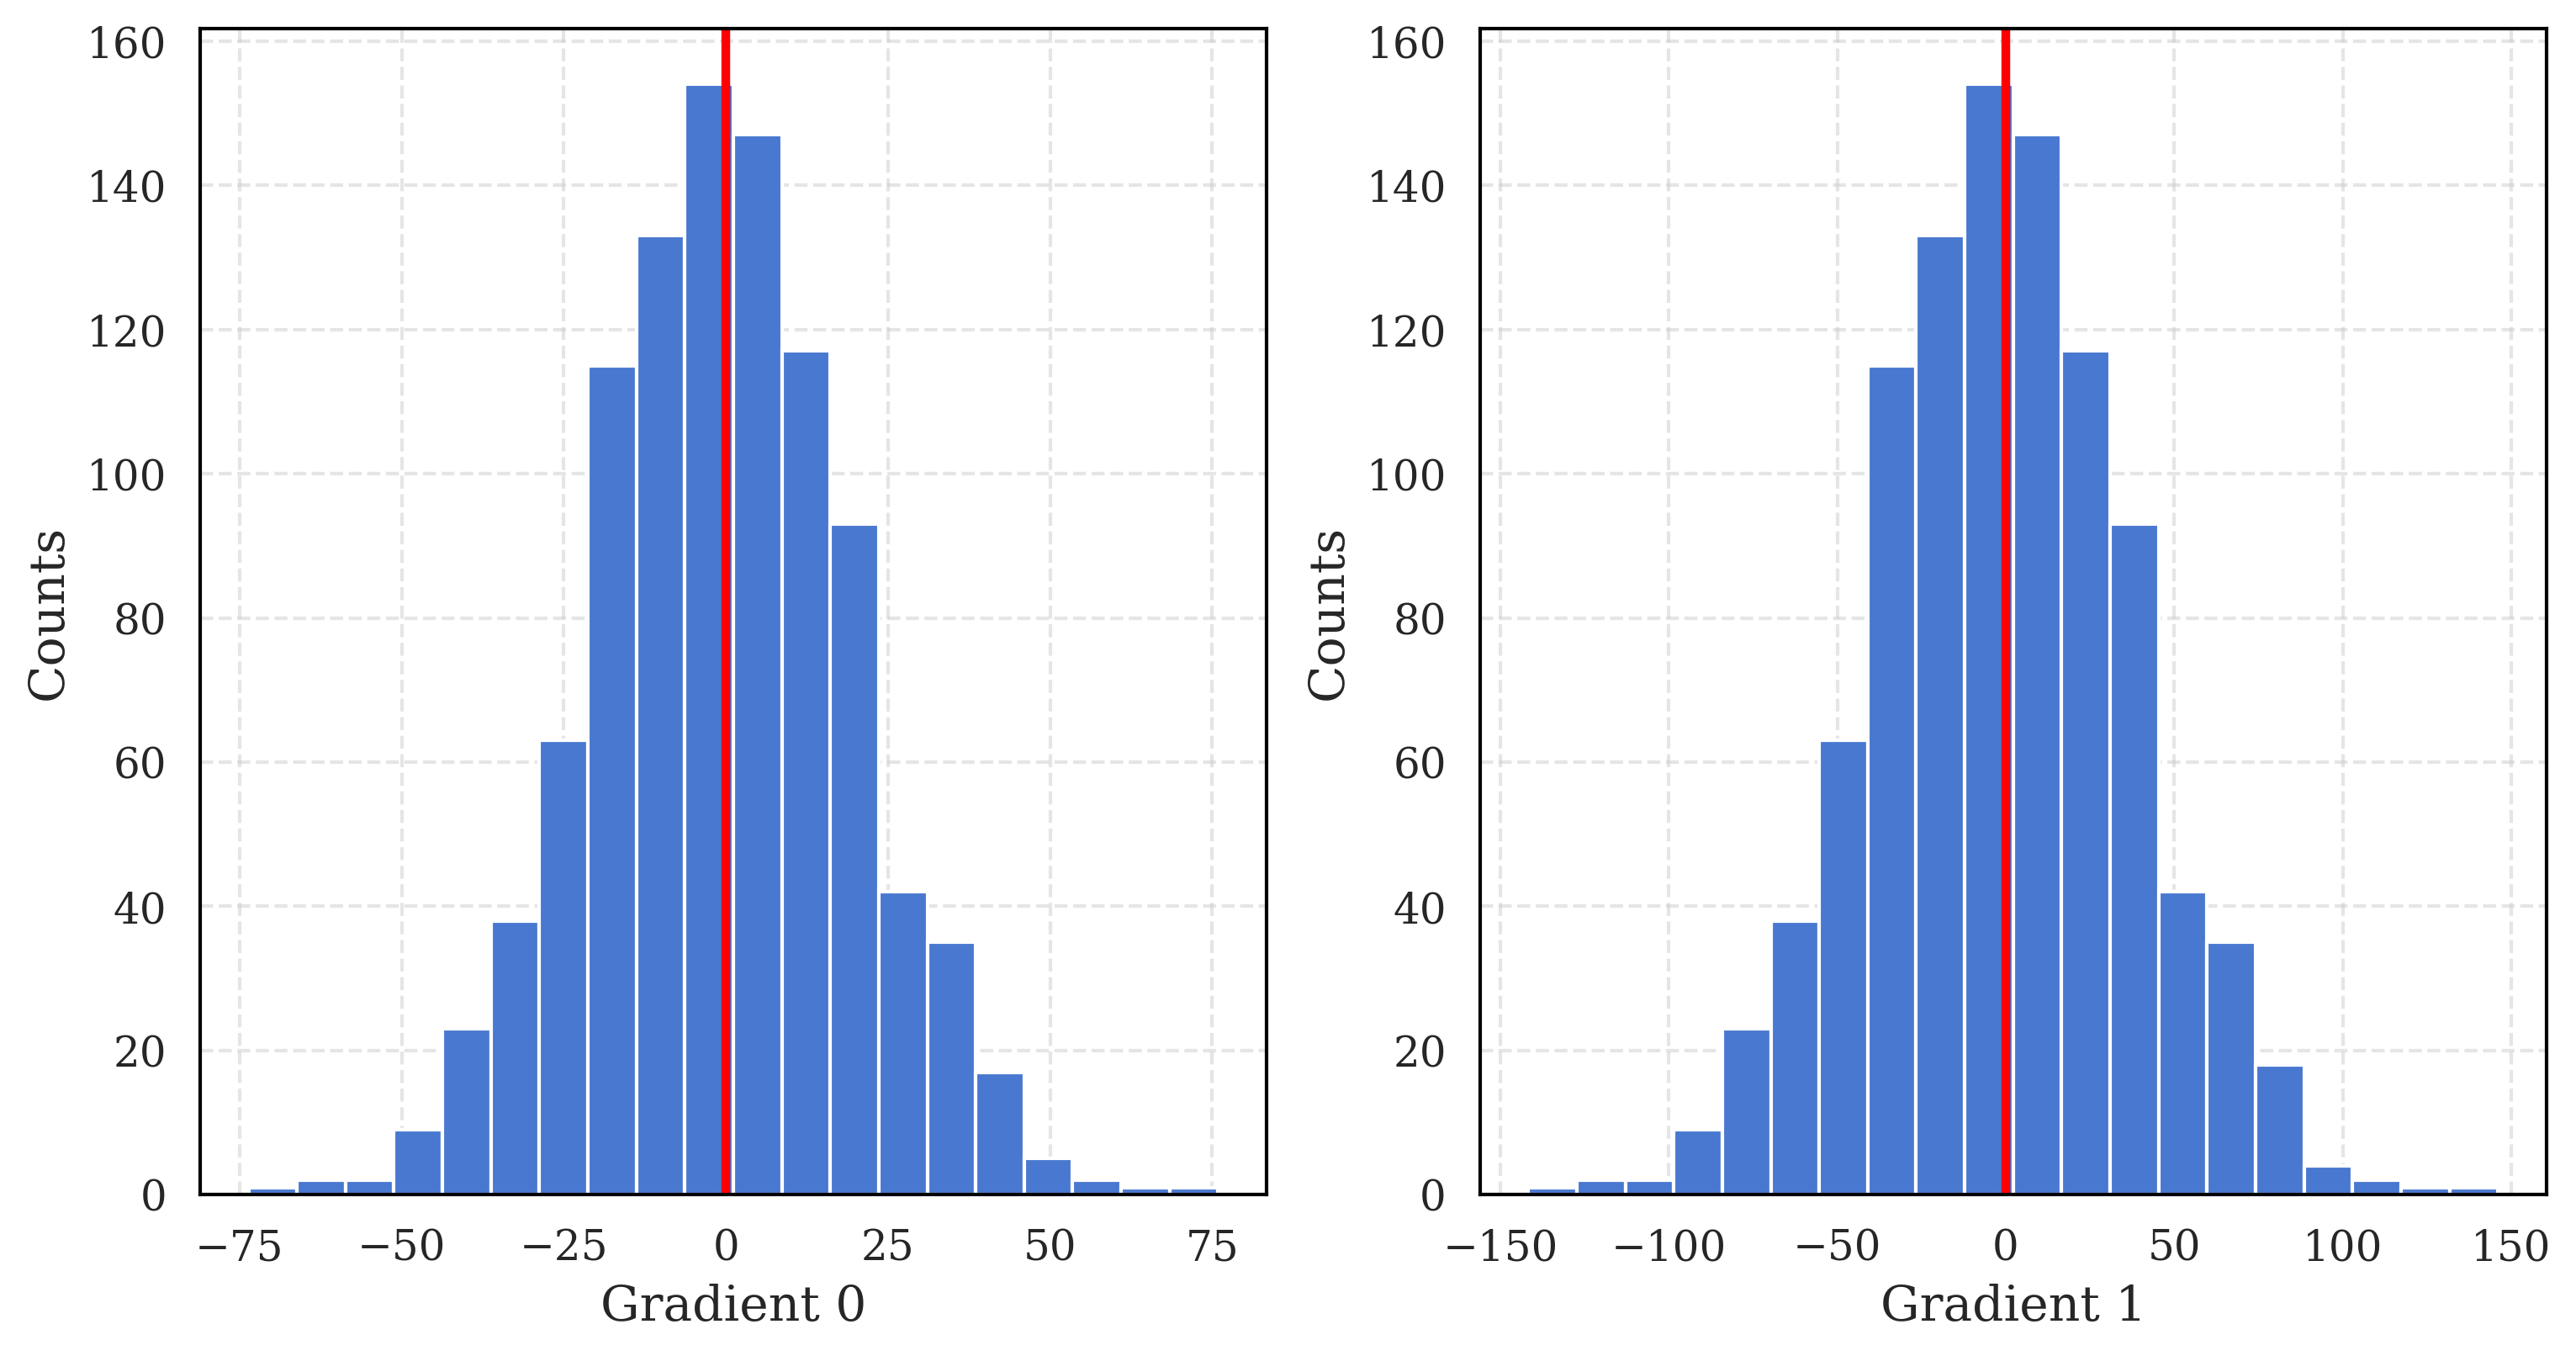

In [6]:
grads = []
for it in range(1000):  # TODO: change to 10000
    y = appd.sample()
    grads.append(-mlmc_gradient_estimator(y, x_adv, 100, model))

# Plot 2 histograms, one for each feature
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    axs[i].hist([grad[i].item() for grad in grads], bins=20)
    axs[i].axvline(real_grad[i].item(), color='red')
    axs[i].set_xlabel(f'Gradient {i}')
    axs[i].set_ylabel('Counts')

In [7]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * sigma2)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=5, R=100, lr=0.001, n_iter=1000)
plot_ppds(model, x, x_adv_distr, appd)

Long gradient estimation time: 2.2664477825164795 for iteration 59
Long gradient estimation time: 2.029801845550537 for iteration 60


In [8]:
# Vector field of perturbations
perturbations = []

for i in range(X_test.shape[0]):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * model.sigma2)
    x_adv, x_adv_values = mlmc_attack(model, x, appd, lr=0.001)
    perturbations.append(x.clone().detach().numpy() - x_adv.clone().detach().numpy())

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=40, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0]),max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1]),max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.1)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

Early stopping at iteration 46
Early stopping at iteration 23
Early stopping at iteration 21
Early stopping at iteration 16
Early stopping at iteration 12
Early stopping at iteration 33
Early stopping at iteration 12
Early stopping at iteration 36
Early stopping at iteration 42
Early stopping at iteration 17
Early stopping at iteration 21
Early stopping at iteration 82
Early stopping at iteration 18
Early stopping at iteration 24
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 20
Early stopping at iteration 113
Early stopping at iteration 16
Early stopping at iteration 51
Early stopping at iteration 16
Early stopping at iteration 63
Early stopping at iteration 15
Early stopping at iteration 24
Early stopping at iteration 45
Early stopping at iteration 22
Early stopping at iteration 25
Early stopping at iteration 28
Early stopping at iteration 22
Early stopping at iteration 37
Early stopping at iteration 12
Early s

In [7]:
# plot KL divergence as a function of the strength of the attack FOR APPD ATTACK
n_jobs = 66
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * model.sigma2)
# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=epsilon, R=100)
    kl = kl_div(model.mu, model.lam, model.sigma2, x, x_adv_distr).item()
    x_fsgm = fgsm_attack(model, x, appd, epsilon=epsilon, R=100)
    kl_fsgm = kl_div(model.mu, model.lam, model.sigma2, x, x_fsgm).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')

<>:30: SyntaxWarning: invalid escape sequence '\e'
<>:30: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_961339/223250292.py:30: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12


/tmp/ipykernel_961339/223250292.py:30: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


ValueError: Expected parameter loc (Tensor of shape (1, 16)) of distribution Normal(loc: torch.Size([1, 16]), scale: torch.Size([1, 16])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<MmBackward0>)

## APPD = N(2*mu, 2*sigma)

In [8]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
appd = torch.distributions.normal.Normal(2 * x.T @ model.mu, 2 * sigma2)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=5, R=100, lr=0.001, n_iter=2000)
plot_ppds(model, x, x_adv_distr, appd)

Long gradient estimation time: 10.968509912490845 for iteration 0


ValueError: Expected parameter loc (Tensor of shape (1, 2)) of distribution Normal(loc: torch.Size([1, 2]), scale: torch.Size([1, 2])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan]], grad_fn=<MmBackward0>)

In [ ]:
# Vector field of perturbations
perturbations = []

for i in range(X_test.shape[0]):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    appd = torch.distributions.normal.Normal(2 * x.T @ model.mu, 2 * model.sigma2)
    x_adv, x_adv_values = mlmc_attack(model, x, appd, lr=0.001)
    perturbations.append(x.clone().detach().numpy() - x_adv.clone().detach().numpy())

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=40, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0]),max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1]),max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.1)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

In [ ]:
# plot KL divergence as a function of the strength of the attack FOR APPD ATTACK
n_jobs = 66
appd = torch.distributions.normal.Normal(2 * x.T @ model.mu, 2 * model.sigma2)
# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=epsilon, R=100)
    kl = kl_div(model.mu, model.lam, model.sigma2, x, x_adv_distr).item()
    x_fsgm = fgsm_attack(model, x, appd, epsilon=epsilon, R=100)
    kl_fsgm = kl_div(model.mu, model.lam, model.sigma2, x, x_fsgm).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')

## Maximum disruption problem

In [ ]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
lr = 0.0
mu_n = model.mu
lam_n = model.lam
sigma2 = model.sigma2
x_adv = x.clone().detach().requires_grad_(True)  
optimizer = SGD([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
kl.backward()
real_grad = x_adv.grad.clone().detach()

In [ ]:
grads = []
for it in range(1000):  # TODO: change to 10000
    y = model.sample_predictive_distribution(x, num_samples=1)
    grads.append(mlmc_gradient_estimator(y, x_adv, 100, model))

# Plot 2 histograms, one for each feature
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    axs[i].hist([grad[i].item() for grad in grads], bins=20)
    axs[i].axvline(real_grad[i].item(), color='red')
    axs[i].set_xlabel(f'Gradient {i}')
    axs[i].set_ylabel('Counts')

In [ ]:
# Vector field of perturbations
perturbations = []

for i in range(X_test.shape[0]):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    x_adv, x_adv_values = mlmc_attack(model, x, lr=0.001)
    perturbations.append(x.clone().detach().numpy() - x_adv.clone().detach().numpy())

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=40, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0]),max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1]),max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.1)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

In [ ]:
# plot KL divergence as a function of the strength of the attack 
n_jobs = 66

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon, R=100)
    kl = kl_div(model.mu, model.lam, model.sigma2, x, x_adv_distr).item()
    x_fsgm = fgsm_attack(model, x, epsilon=epsilon, R=100)
    kl_fsgm = kl_div(model.mu, model.lam, model.sigma2, x, x_fsgm).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')